# About this notebook

- PyTorch se_resnext50  
- 4 folds 
- Also used tiling from iafoss
- https://www.kaggle.com/iafoss/panda-16x128x128-tiles
- https://www.kaggle.com/iafoss/panda-concat-tile-pooling-starter-0-79-lb
- https://www.kaggle.com/iafoss/panda-concat-tile-pooling-starter-inference 

# What was done:
- Write a function so that we can lower the resolution to any target_resolution. 
- Run with BCE_loss, different epochs
- Split the training set so only a subset is used during exploratory experiments

# Config

In [30]:
class CFG:
    debug=False
    lr=1e-4
    batch_size=16
    epochs=10 # 10 was used, more for final submission.
    seed=777
    target_size=1
    target_col='isup_grade'
    n_fold=4

# Library

In [31]:
# Load libraries
import os
import numpy as np 
import pandas as pd 

In [32]:
os.listdir('../input/prostate-cancer-grade-assessment')

['sample_submission.csv',
 'train_images',
 'train_label_masks',
 'train.csv',
 'test.csv']

# Data Loading

In [33]:
# Load data
train = pd.read_csv('../input/prostate-cancer-grade-assessment/train.csv')
test = pd.read_csv('../input/prostate-cancer-grade-assessment/test.csv')
sample = pd.read_csv('../input/prostate-cancer-grade-assessment/sample_submission.csv')

# Take subset for exploratory experiments. For final experiments this is commented.
train = train.sample(3000, random_state = 42).reset_index(drop=True)

In [34]:
train.head()

,image_id,data_provider,isup_grade,gleason_score
0,e8baa3bb9dcfb9cef5ca599d62bb8046,karolinska,4,4+4
1,9b2948ff81b64677a1a152a1532c1a50,karolinska,2,3+4
2,5b003d43ec0ce5979062442486f84cf7,radboud,4,5+3
3,375b2c9501320b35ceb638a3274812aa,radboud,1,3+3
4,e4e49a91640feea58d109aff11df4197,karolinska,1,3+3


In [35]:
test.head()

,image_id,data_provider
0,005700be7e06878e6605e7a5a39de1b2,radboud
1,005c6e8877caf724c600fdce5d417d40,karolinska
2,0104f76634ff89bfff1ef0804a95c380,radboud


In [36]:
sample.head()

,image_id,isup_grade
0,005700be7e06878e6605e7a5a39de1b2,0
1,005c6e8877caf724c600fdce5d417d40,0
2,0104f76634ff89bfff1ef0804a95c380,0


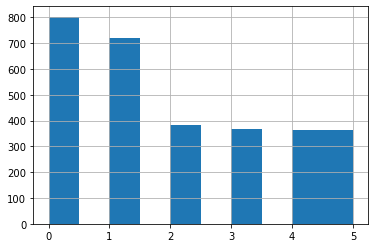

In [37]:
train['isup_grade'].hist()

# Library

In [38]:
# ====================================================
# Library
# ====================================================

import sys

import gc
import os
import random
import time
from contextlib import contextmanager
from pathlib import Path
from collections import defaultdict, Counter

import skimage.io
import cv2
from PIL import Image
import numpy as np
import pandas as pd
import scipy as sp

import sklearn.metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

from functools import partial
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset
import torchvision.models as models

from albumentations import Compose, Normalize, HorizontalFlip, VerticalFlip
from albumentations.pytorch import ToTensorV2

import warnings 
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [39]:
# # Uncomment when tracking the progress with weights and biases. Change internet to on
# !pip install wandb
# import wandb
# wandb.login()

True

# Utils

In [41]:
# ====================================================
# Utils
# ====================================================

@contextmanager
def timer(name):
    t0 = time.time()
    LOGGER.info(f'[{name}] start')
    yield
    LOGGER.info(f'[{name}] done in {time.time() - t0:.0f} s.')

    
def init_logger(log_file='train.log'):
    from logging import getLogger, DEBUG, FileHandler,  Formatter,  StreamHandler
    
    log_format = '%(asctime)s %(levelname)s %(message)s'
    
    stream_handler = StreamHandler()
    stream_handler.setLevel(DEBUG)
    stream_handler.setFormatter(Formatter(log_format))
    
    file_handler = FileHandler(log_file)
    file_handler.setFormatter(Formatter(log_format))
    
    logger = getLogger('PANDA')
    logger.setLevel(DEBUG)
    logger.addHandler(stream_handler)
    logger.addHandler(file_handler)
    
    return logger

LOG_FILE = 'train.log'
LOGGER = init_logger(LOG_FILE)


def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed=42)

# Dataset

In [42]:
def tile(img, sz=128, N=16, target_resolution=None):
    shape = img.shape     
    
    # Added this part to resize to lower resolution. If we accidently set target_resolution too high it will take the original resolution
    if target_resolution is not None:
        # Resize the image to the target resolution
        target_resolution = (min(target_resolution[0], shape[1]), min(target_resolution[1], shape[0]))
        img = Image.fromarray(img)
        img = img.resize(target_resolution, Image.ANTIALIAS)
        img = np.array(img)
        shape = img.shape
    
    pad0,pad1 = (sz - shape[0]%sz)%sz, (sz - shape[1]%sz)%sz
    img = np.pad(img,[[pad0//2,pad0-pad0//2],[pad1//2,pad1-pad1//2],[0,0]],
                 constant_values=255)
    img = img.reshape(img.shape[0]//sz,sz,img.shape[1]//sz,sz,3)
    img = img.transpose(0,2,1,3,4).reshape(-1,sz,sz,3)
    if len(img) < N:
        img = np.pad(img,[[0,N-len(img)],[0,0],[0,0],[0,0]],constant_values=255)
    
    idxs = np.argsort(img.reshape(img.shape[0],-1).sum(-1))[:N]
    img = img[idxs]
    return img

In [43]:
class TrainDataset(Dataset):
    def __init__(self, df, labels, transform=None):
        self.df = df
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.df['image_id'].values[idx]
        file_path = f'../input/prostate-cancer-grade-assessment/train_images/{file_name}.tiff'
        image = skimage.io.MultiImage(file_path)[-1]
        image = tile(image, sz=128, N=16, target_resolution=None)
        image = cv2.hconcat([cv2.vconcat([image[0], image[1], image[2], image[3]]), 
                             cv2.vconcat([image[4], image[5], image[6], image[7]]), 
                             cv2.vconcat([image[8], image[9], image[10], image[11]]), 
                             cv2.vconcat([image[12], image[13], image[14], image[15]])])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
            
        label = torch.tensor(self.labels[idx]).float()
        
        return image, label
    

class TestDataset(Dataset):
    def __init__(self, df, dir_name, transform=None):
        self.df = df
        self.dir_name = dir_name
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.df['image_id'].values[idx]
        file_path = f'../input/prostate-cancer-grade-assessment/{self.dir_name}/{file_name}.tiff'
        image = skimage.io.MultiImage(file_path)[-1]
        image = tile(image, sz=128, N=16, target_resolution=None)
        image = cv2.hconcat([cv2.vconcat([image[0], image[1], image[2], image[3]]), 
                             cv2.vconcat([image[4], image[5], image[6], image[7]]), 
                             cv2.vconcat([image[8], image[9], image[10], image[11]]), 
                             cv2.vconcat([image[12], image[13], image[14], image[15]])])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        
        return image

In [44]:
import matplotlib.pyplot as plt

train_dataset = TrainDataset(train, train[CFG.target_col], transform=None)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)

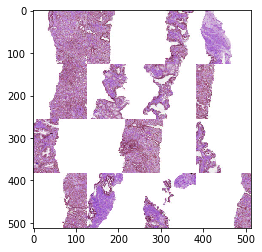

CPU times: user 209 ms, sys: 9.13 ms, total: 219 ms
Wall time: 219 ms


In [45]:
%%time

for image, label in train_loader:
    plt.imshow(image[0])
    plt.show()  
    break

# Transforms

In [46]:
def get_transforms(*, data):
    
    assert data in ('train', 'valid')
    
    if data == 'train':
        return Compose([
            HorizontalFlip(p=0.5),
            VerticalFlip(p=0.5),
            Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])
    
    elif data == 'valid':
        return Compose([
            Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

# train valid split

In [47]:
if CFG.debug:
    folds = train.sample(n=1000, random_state=CFG.seed).reset_index(drop=True).copy()
else:
    folds = train.copy()

In [48]:
train_labels = folds[CFG.target_col].values
kf = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for fold, (train_index, val_index) in enumerate(kf.split(folds.values, train_labels)):
    folds.loc[val_index, 'fold'] = int(fold)
folds['fold'] = folds['fold'].astype(int)
folds.to_csv('folds.csv', index=None)
folds.head()

,image_id,data_provider,isup_grade,gleason_score,fold
0,e8baa3bb9dcfb9cef5ca599d62bb8046,karolinska,4,4+4,0
1,9b2948ff81b64677a1a152a1532c1a50,karolinska,2,3+4,2
2,5b003d43ec0ce5979062442486f84cf7,radboud,4,5+3,1
3,375b2c9501320b35ceb638a3274812aa,radboud,1,3+3,3
4,e4e49a91640feea58d109aff11df4197,karolinska,1,3+3,1


# Model

In [49]:
# https://github.com/Cadene/pretrained-models.pytorch/blob/master/pretrainedmodels/models/senet.py

from collections import OrderedDict
import math


class SEModule(nn.Module):

    def __init__(self, channels, reduction):
        super(SEModule, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Conv2d(channels, channels // reduction, kernel_size=1,
                             padding=0)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Conv2d(channels // reduction, channels, kernel_size=1,
                             padding=0)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        module_input = x
        x = self.avg_pool(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return module_input * x


class Bottleneck(nn.Module):
    """
    Base class for bottlenecks that implements `forward()` method.
    """
    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out = self.se_module(out) + residual
        out = self.relu(out)

        return out


class SEBottleneck(Bottleneck):
    """
    Bottleneck for SENet154.
    """
    expansion = 4

    def __init__(self, inplanes, planes, groups, reduction, stride=1,
                 downsample=None):
        super(SEBottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes * 2, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes * 2)
        self.conv2 = nn.Conv2d(planes * 2, planes * 4, kernel_size=3,
                               stride=stride, padding=1, groups=groups,
                               bias=False)
        self.bn2 = nn.BatchNorm2d(planes * 4)
        self.conv3 = nn.Conv2d(planes * 4, planes * 4, kernel_size=1,
                               bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.se_module = SEModule(planes * 4, reduction=reduction)
        self.downsample = downsample
        self.stride = stride


class SEResNetBottleneck(Bottleneck):
    """
    ResNet bottleneck with a Squeeze-and-Excitation module. It follows Caffe
    implementation and uses `stride=stride` in `conv1` and not in `conv2`
    (the latter is used in the torchvision implementation of ResNet).
    """
    expansion = 4

    def __init__(self, inplanes, planes, groups, reduction, stride=1,
                 downsample=None):
        super(SEResNetBottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False,
                               stride=stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, padding=1,
                               groups=groups, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.se_module = SEModule(planes * 4, reduction=reduction)
        self.downsample = downsample
        self.stride = stride


class SEResNeXtBottleneck(Bottleneck):
    """
    ResNeXt bottleneck type C with a Squeeze-and-Excitation module.
    """
    expansion = 4

    def __init__(self, inplanes, planes, groups, reduction, stride=1,
                 downsample=None, base_width=4):
        super(SEResNeXtBottleneck, self).__init__()
        width = math.floor(planes * (base_width / 64)) * groups
        self.conv1 = nn.Conv2d(inplanes, width, kernel_size=1, bias=False,
                               stride=1)
        self.bn1 = nn.BatchNorm2d(width)
        self.conv2 = nn.Conv2d(width, width, kernel_size=3, stride=stride,
                               padding=1, groups=groups, bias=False)
        self.bn2 = nn.BatchNorm2d(width)
        self.conv3 = nn.Conv2d(width, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.se_module = SEModule(planes * 4, reduction=reduction)
        self.downsample = downsample
        self.stride = stride


class SENet(nn.Module):

    def __init__(self, block, layers, groups, reduction, dropout_p=0.2,
                 inplanes=128, input_3x3=True, downsample_kernel_size=3,
                 downsample_padding=1, num_classes=1000):
        super(SENet, self).__init__()
        self.inplanes = inplanes
        if input_3x3:
            layer0_modules = [
                ('conv1', nn.Conv2d(3, 64, 3, stride=2, padding=1,
                                    bias=False)),
                ('bn1', nn.BatchNorm2d(64)),
                ('relu1', nn.ReLU(inplace=True)),
                ('conv2', nn.Conv2d(64, 64, 3, stride=1, padding=1,
                                    bias=False)),
                ('bn2', nn.BatchNorm2d(64)),
                ('relu2', nn.ReLU(inplace=True)),
                ('conv3', nn.Conv2d(64, inplanes, 3, stride=1, padding=1,
                                    bias=False)),
                ('bn3', nn.BatchNorm2d(inplanes)),
                ('relu3', nn.ReLU(inplace=True)),
            ]
        else:
            layer0_modules = [
                ('conv1', nn.Conv2d(3, inplanes, kernel_size=7, stride=2,
                                    padding=3, bias=False)),
                ('bn1', nn.BatchNorm2d(inplanes)),
                ('relu1', nn.ReLU(inplace=True)),
            ]
        # To preserve compatibility with Caffe weights `ceil_mode=True`
        # is used instead of `padding=1`.
        layer0_modules.append(('pool', nn.MaxPool2d(3, stride=2,
                                                    ceil_mode=True)))
        self.layer0 = nn.Sequential(OrderedDict(layer0_modules))
        self.layer1 = self._make_layer(
            block,
            planes=64,
            blocks=layers[0],
            groups=groups,
            reduction=reduction,
            downsample_kernel_size=1,
            downsample_padding=0
        )
        self.layer2 = self._make_layer(
            block,
            planes=128,
            blocks=layers[1],
            stride=2,
            groups=groups,
            reduction=reduction,
            downsample_kernel_size=downsample_kernel_size,
            downsample_padding=downsample_padding
        )
        self.layer3 = self._make_layer(
            block,
            planes=256,
            blocks=layers[2],
            stride=2,
            groups=groups,
            reduction=reduction,
            downsample_kernel_size=downsample_kernel_size,
            downsample_padding=downsample_padding
        )
        self.layer4 = self._make_layer(
            block,
            planes=512,
            blocks=layers[3],
            stride=2,
            groups=groups,
            reduction=reduction,
            downsample_kernel_size=downsample_kernel_size,
            downsample_padding=downsample_padding
        )
        self.avg_pool = nn.AvgPool2d(7, stride=1)
        self.dropout = nn.Dropout(dropout_p) if dropout_p is not None else None
        self.last_linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, blocks, groups, reduction, stride=1,
                    downsample_kernel_size=1, downsample_padding=0):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=downsample_kernel_size, stride=stride,
                          padding=downsample_padding, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, groups, reduction, stride,
                            downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups, reduction))

        return nn.Sequential(*layers)

    def features(self, x):
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return x

    def logits(self, x):
        x = self.avg_pool(x)
        if self.dropout is not None:
            x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = self.last_linear(x)
        return x

    def forward(self, x):
        x = self.features(x)
        x = self.logits(x)
        return x


def initialize_pretrained_model(model, num_classes, settings):
    assert num_classes == settings['num_classes'], \
        'num_classes should be {}, but is {}'.format(
            settings['num_classes'], num_classes)
    model.load_state_dict(model_zoo.load_url(settings['url']))
    model.input_space = settings['input_space']
    model.input_size = settings['input_size']
    model.input_range = settings['input_range']
    model.mean = settings['mean']
    model.std = settings['std']


def se_resnext50_32x4d(num_classes=1000, pretrained='imagenet'):
    model = SENet(SEResNeXtBottleneck, [3, 4, 6, 3], groups=32, reduction=16,
                  dropout_p=None, inplanes=64, input_3x3=False,
                  downsample_kernel_size=1, downsample_padding=0,
                  num_classes=num_classes)
    if pretrained is not None:
        settings = pretrained_settings['se_resnext50_32x4d'][pretrained]
        initialize_pretrained_model(model, num_classes, settings)
    return model


def se_resnext101_32x4d(num_classes=1000, pretrained='imagenet'):
    model = SENet(SEResNeXtBottleneck, [3, 4, 23, 3], groups=32, reduction=16,
                  dropout_p=None, inplanes=64, input_3x3=False,
                  downsample_kernel_size=1, downsample_padding=0,
                  num_classes=num_classes)
    if pretrained is not None:
        settings = pretrained_settings['se_resnext101_32x4d'][pretrained]
        initialize_pretrained_model(model, num_classes, settings)
    return model

In [50]:
pretrained_path = {'se_resnext50_32x4d': '../input/pytorch-se-resnext/se_resnext50_32x4d-a260b3a4.pth'}

class CustomSEResNeXt(nn.Module):

    def __init__(self, model_name='se_resnext50_32x4d'):
        assert model_name in ('se_resnext50_32x4d')
        super().__init__()
        
        self.model = se_resnext50_32x4d(pretrained=None)
        weights_path = pretrained_path[model_name]
        self.model.load_state_dict(torch.load(weights_path))
        self.model.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.model.last_linear = nn.Linear(self.model.last_linear.in_features, CFG.target_size)
        
    def forward(self, x):
        x = self.model(x)
        return x

# Train

In [51]:
from sklearn.metrics import cohen_kappa_score

def quadratic_weighted_kappa(y_hat, y):
    return cohen_kappa_score(y_hat, y, weights='quadratic')


class OptimizedRounder():
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            elif pred >= coef[3] and pred < coef[4]:
                X_p[i] = 4
            else:
                X_p[i] = 5

        ll = quadratic_weighted_kappa(y, X_p)
        return -ll

    def fit(self, X, y):
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5, 3.5, 4.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')

    def predict(self, X, coef):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            elif pred >= coef[3] and pred < coef[4]:
                X_p[i] = 4
            else:
                X_p[i] = 5
        return X_p

    def coefficients(self):
        return self.coef_['x']

In [52]:
def train_fn(fold):
    
    print(f"### fold: {fold} ###")
    
    optimized_rounder = OptimizedRounder()
        
    trn_idx = folds[folds['fold'] != fold].index
    val_idx = folds[folds['fold'] == fold].index
        
    train_dataset = TrainDataset(folds.loc[trn_idx].reset_index(drop=True), 
                                 folds.loc[trn_idx].reset_index(drop=True)[CFG.target_col], 
                                 transform=get_transforms(data='train'))
    valid_dataset = TrainDataset(folds.loc[val_idx].reset_index(drop=True), 
                                 folds.loc[val_idx].reset_index(drop=True)[CFG.target_col], 
                                 transform=get_transforms(data='valid'))
    
    train_loader = DataLoader(train_dataset, batch_size=CFG.batch_size, shuffle=True, num_workers=4)
    valid_loader = DataLoader(valid_dataset, batch_size=CFG.batch_size, shuffle=False, num_workers=4)
    
    model = CustomSEResNeXt(model_name='se_resnext50_32x4d')
    model.to(device)
    
    optimizer = Adam(model.parameters(), lr=CFG.lr, amsgrad=False)
    scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=2, verbose=True, eps=1e-6)
    
    # Different criterions were used
    criterion = nn.MSELoss()
    #criterion = nn.BCEWithLogitsLoss()
    
    best_score = -100
    best_loss = np.inf
    best_preds = None
    
    
    for epoch in range(CFG.epochs):
        
        start_time = time.time()

        model.train()
        avg_loss = 0.

        optimizer.zero_grad()
        tk0 = tqdm(enumerate(train_loader), total=len(train_loader), position=0, leave=True)

        for i, (images, labels) in tk0:

            images = images.to(device)
            labels = labels.to(device)
            
            y_preds = model(images)
            loss = criterion(y_preds.view(-1), labels)
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            avg_loss += loss.item() / len(train_loader)
            
        model.eval()
        avg_val_loss = 0.
        preds = []
        valid_labels = []
        tk1 = tqdm(enumerate(valid_loader), total=len(valid_loader), position=0, leave=True)

        for i, (images, labels) in tk1:
            
            images = images.to(device)
            labels = labels.to(device)
            
            with torch.no_grad():
                y_preds = model(images)
            
            preds.append(y_preds.to('cpu').numpy())
            valid_labels.append(labels.to('cpu').numpy())

            loss = criterion(y_preds.view(-1), labels)
            avg_val_loss += loss.item() / len(valid_loader)
        
        scheduler.step(avg_val_loss)
            
        preds = np.concatenate(preds)
        valid_labels = np.concatenate(valid_labels)
        
        optimized_rounder.fit(preds, valid_labels)
        coefficients = optimized_rounder.coefficients()
        final_preds = optimized_rounder.predict(preds, coefficients)
        LOGGER.debug(f'Counter preds: {Counter(np.concatenate(final_preds))}')
        LOGGER.debug(f'coefficients: {coefficients}')
        score = quadratic_weighted_kappa(valid_labels, final_preds)

        elapsed = time.time() - start_time
        
        LOGGER.debug(f'  Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.debug(f'  Epoch {epoch+1} - QWK: {score}  coefficients: {coefficients}')
        wandb.log({'training loss': avg_loss, "validation_loss": avg_val_loss, 'QWK': score})
        
        if score>best_score:
            best_score = score
            best_preds = preds
            LOGGER.debug(f'  Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model  coefficients: {coefficients}')
            torch.save(model.state_dict(), f'fold{fold}_se_resnext50.pth')
        
        
            
    
    return best_preds, valid_labels

In [53]:
preds = []
valid_labels = []
for fold in range(CFG.n_fold):
#     # If we want to track progress with weights and biases
#     run = wandb.init(
#     # Set the project where this run will be logged
#     project="ismi",
#     # Track hyperparameters and run metadata
#     config={
#         "model": "bcewithdigits",
#         "which_fold": fold,
#         "learning_rate": 1e-4,
#         "epochs": 10,
#         "batch_size": 16,
#         "fold": 4,
#     })
    _preds, _valid_labels = train_fn(fold)
    preds.append(_preds)
    valid_labels.append(_valid_labels)

wandb: Wandb version 0.15.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


### fold: 0 ###


100%|██████████| 47/47 [00:21<00:00,  2.16it/s]
2023-06-01 13:33:36,930 DEBUG Counter preds: Counter({0.0: 585, 5.0: 150, 1.0: 13, 3.0: 2})
2023-06-01 13:33:36,930 DEBUG Counter preds: Counter({0.0: 585, 5.0: 150, 1.0: 13, 3.0: 2})
2023-06-01 13:33:36,934 DEBUG coefficients: [0.475 1.53  2.55  3.57  4.59 ]
2023-06-01 13:33:36,934 DEBUG coefficients: [0.475 1.53  2.55  3.57  4.59 ]
2023-06-01 13:33:36,942 DEBUG   Epoch 1 - avg_train_loss: -69.1319  avg_val_loss: -396.2916  time: 129s
2023-06-01 13:33:36,942 DEBUG   Epoch 1 - avg_train_loss: -69.1319  avg_val_loss: -396.2916  time: 129s
2023-06-01 13:33:36,945 DEBUG   Epoch 1 - QWK: 0.4381301732412167  coefficients: [0.475 1.53  2.55  3.57  4.59 ]
2023-06-01 13:33:36,945 DEBUG   Epoch 1 - QWK: 0.4381301732412167  coefficients: [0.475 1.53  2.55  3.57  4.59 ]
2023-06-01 13:33:36,959 DEBUG   Epoch 1 - Save Best Score: 0.4381 Model  coefficients: [0.475 1.53  2.55  3.57  4.59 ]
2023-06-01 13:33:36,959 DEBUG   Epoch 1 - Save Best Score: 0.43

wandb: Wandb version 0.15.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


### fold: 1 ###


100%|██████████| 47/47 [00:22<00:00,  2.13it/s]
2023-06-01 13:55:16,958 DEBUG Counter preds: Counter({1.0: 357, 0.0: 336, 5.0: 54, 2.0: 1, 3.0: 1, 4.0: 1})
2023-06-01 13:55:16,958 DEBUG Counter preds: Counter({1.0: 357, 0.0: 336, 5.0: 54, 2.0: 1, 3.0: 1, 4.0: 1})
2023-06-01 13:55:16,963 DEBUG coefficients: [0.32428239 1.69714096 2.66202226 3.82342949 4.7556257 ]
2023-06-01 13:55:16,963 DEBUG coefficients: [0.32428239 1.69714096 2.66202226 3.82342949 4.7556257 ]
2023-06-01 13:55:16,970 DEBUG   Epoch 1 - avg_train_loss: -69.4109  avg_val_loss: -183.8147  time: 130s
2023-06-01 13:55:16,970 DEBUG   Epoch 1 - avg_train_loss: -69.4109  avg_val_loss: -183.8147  time: 130s
2023-06-01 13:55:16,973 DEBUG   Epoch 1 - QWK: 0.3235717609300178  coefficients: [0.32428239 1.69714096 2.66202226 3.82342949 4.7556257 ]
2023-06-01 13:55:16,973 DEBUG   Epoch 1 - QWK: 0.3235717609300178  coefficients: [0.32428239 1.69714096 2.66202226 3.82342949 4.7556257 ]
2023-06-01 13:55:16,985 DEBUG   Epoch 1 - Save Bes

Epoch     6: reducing learning rate of group 0 to 5.0000e-05.


2023-06-01 14:06:09,453 DEBUG Counter preds: Counter({1.0: 443, 5.0: 203, 2.0: 64, 4.0: 22, 3.0: 18})
2023-06-01 14:06:09,453 DEBUG Counter preds: Counter({1.0: 443, 5.0: 203, 2.0: 64, 4.0: 22, 3.0: 18})
2023-06-01 14:06:09,459 DEBUG coefficients: [0.50361437 1.54019491 2.61473405 3.40546186 4.26132613]
2023-06-01 14:06:09,459 DEBUG coefficients: [0.50361437 1.54019491 2.61473405 3.40546186 4.26132613]
2023-06-01 14:06:09,465 DEBUG   Epoch 6 - avg_train_loss: -708.4010  avg_val_loss: -590.5150  time: 131s
2023-06-01 14:06:09,465 DEBUG   Epoch 6 - avg_train_loss: -708.4010  avg_val_loss: -590.5150  time: 131s
2023-06-01 14:06:09,468 DEBUG   Epoch 6 - QWK: 0.5631338210884798  coefficients: [0.50361437 1.54019491 2.61473405 3.40546186 4.26132613]
2023-06-01 14:06:09,468 DEBUG   Epoch 6 - QWK: 0.5631338210884798  coefficients: [0.50361437 1.54019491 2.61473405 3.40546186 4.26132613]
100%|██████████| 47/47 [00:21<00:00,  2.19it/s]
2023-06-01 14:08:20,900 DEBUG Counter preds: Counter({1.0: 3

Epoch    10: reducing learning rate of group 0 to 2.5000e-05.


2023-06-01 14:14:49,543 DEBUG Counter preds: Counter({1.0: 393, 5.0: 240, 2.0: 69, 4.0: 25, 3.0: 23})
2023-06-01 14:14:49,543 DEBUG Counter preds: Counter({1.0: 393, 5.0: 240, 2.0: 69, 4.0: 25, 3.0: 23})
2023-06-01 14:14:49,552 DEBUG coefficients: [0.46600598 1.60737419 2.64436195 3.33080902 4.67837904]
2023-06-01 14:14:49,552 DEBUG coefficients: [0.46600598 1.60737419 2.64436195 3.33080902 4.67837904]
2023-06-01 14:14:49,561 DEBUG   Epoch 10 - avg_train_loss: -1008.9797  avg_val_loss: -1311.8443  time: 130s
2023-06-01 14:14:49,561 DEBUG   Epoch 10 - avg_train_loss: -1008.9797  avg_val_loss: -1311.8443  time: 130s
2023-06-01 14:14:49,568 DEBUG   Epoch 10 - QWK: 0.5245756576301182  coefficients: [0.46600598 1.60737419 2.64436195 3.33080902 4.67837904]
2023-06-01 14:14:49,568 DEBUG   Epoch 10 - QWK: 0.5245756576301182  coefficients: [0.46600598 1.60737419 2.64436195 3.33080902 4.67837904]


wandb: Wandb version 0.15.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


### fold: 2 ###


100%|██████████| 47/47 [00:21<00:00,  2.18it/s]
2023-06-01 14:16:59,307 DEBUG Counter preds: Counter({0.0: 625, 5.0: 124, 1.0: 1})
2023-06-01 14:16:59,307 DEBUG Counter preds: Counter({0.0: 625, 5.0: 124, 1.0: 1})
2023-06-01 14:16:59,311 DEBUG coefficients: [0.5 1.5 2.5 3.5 4.5]
2023-06-01 14:16:59,311 DEBUG coefficients: [0.5 1.5 2.5 3.5 4.5]
2023-06-01 14:16:59,319 DEBUG   Epoch 1 - avg_train_loss: -65.9316  avg_val_loss: -174.4871  time: 129s
2023-06-01 14:16:59,319 DEBUG   Epoch 1 - avg_train_loss: -65.9316  avg_val_loss: -174.4871  time: 129s
2023-06-01 14:16:59,321 DEBUG   Epoch 1 - QWK: 0.3611346193936198  coefficients: [0.5 1.5 2.5 3.5 4.5]
2023-06-01 14:16:59,321 DEBUG   Epoch 1 - QWK: 0.3611346193936198  coefficients: [0.5 1.5 2.5 3.5 4.5]
2023-06-01 14:16:59,339 DEBUG   Epoch 1 - Save Best Score: 0.3611 Model  coefficients: [0.5 1.5 2.5 3.5 4.5]
2023-06-01 14:16:59,339 DEBUG   Epoch 1 - Save Best Score: 0.3611 Model  coefficients: [0.5 1.5 2.5 3.5 4.5]
100%|██████████| 47/47

Epoch     5: reducing learning rate of group 0 to 5.0000e-05.


2023-06-01 14:25:40,386 DEBUG Counter preds: Counter({1.0: 506, 5.0: 157, 2.0: 60, 3.0: 21, 4.0: 6})
2023-06-01 14:25:40,386 DEBUG Counter preds: Counter({1.0: 506, 5.0: 157, 2.0: 60, 3.0: 21, 4.0: 6})
2023-06-01 14:25:40,391 DEBUG coefficients: [0.51861058 1.48290694 2.51937119 3.57445869 4.26900554]
2023-06-01 14:25:40,391 DEBUG coefficients: [0.51861058 1.48290694 2.51937119 3.57445869 4.26900554]
2023-06-01 14:25:40,397 DEBUG   Epoch 5 - avg_train_loss: -472.6839  avg_val_loss: -170.1744  time: 130s
2023-06-01 14:25:40,397 DEBUG   Epoch 5 - avg_train_loss: -472.6839  avg_val_loss: -170.1744  time: 130s
2023-06-01 14:25:40,399 DEBUG   Epoch 5 - QWK: 0.5119493015115113  coefficients: [0.51861058 1.48290694 2.51937119 3.57445869 4.26900554]
2023-06-01 14:25:40,399 DEBUG   Epoch 5 - QWK: 0.5119493015115113  coefficients: [0.51861058 1.48290694 2.51937119 3.57445869 4.26900554]
100%|██████████| 47/47 [00:21<00:00,  2.17it/s]
2023-06-01 14:27:50,244 DEBUG Counter preds: Counter({1.0: 378

Epoch     9: reducing learning rate of group 0 to 2.5000e-05.


2023-06-01 14:34:19,744 DEBUG Counter preds: Counter({1.0: 440, 5.0: 229, 2.0: 47, 3.0: 24, 4.0: 10})
2023-06-01 14:34:19,744 DEBUG Counter preds: Counter({1.0: 440, 5.0: 229, 2.0: 47, 3.0: 24, 4.0: 10})
2023-06-01 14:34:19,748 DEBUG coefficients: [0.50209073 1.50513594 2.42827464 3.5942601  4.67987317]
2023-06-01 14:34:19,748 DEBUG coefficients: [0.50209073 1.50513594 2.42827464 3.5942601  4.67987317]
2023-06-01 14:34:19,755 DEBUG   Epoch 9 - avg_train_loss: -877.9183  avg_val_loss: -1063.5940  time: 130s
2023-06-01 14:34:19,755 DEBUG   Epoch 9 - avg_train_loss: -877.9183  avg_val_loss: -1063.5940  time: 130s
2023-06-01 14:34:19,759 DEBUG   Epoch 9 - QWK: 0.6640256496192016  coefficients: [0.50209073 1.50513594 2.42827464 3.5942601  4.67987317]
2023-06-01 14:34:19,759 DEBUG   Epoch 9 - QWK: 0.6640256496192016  coefficients: [0.50209073 1.50513594 2.42827464 3.5942601  4.67987317]
100%|██████████| 47/47 [00:21<00:00,  2.23it/s]
2023-06-01 14:36:28,727 DEBUG Counter preds: Counter({1.0:

wandb: Wandb version 0.15.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


### fold: 3 ###


100%|██████████| 47/47 [00:21<00:00,  2.16it/s]
2023-06-01 14:38:39,357 DEBUG Counter preds: Counter({0.0: 623, 5.0: 123, 1.0: 2, 2.0: 2})
2023-06-01 14:38:39,357 DEBUG Counter preds: Counter({0.0: 623, 5.0: 123, 1.0: 2, 2.0: 2})
2023-06-01 14:38:39,361 DEBUG coefficients: [0.5 1.5 2.5 3.5 4.5]
2023-06-01 14:38:39,361 DEBUG coefficients: [0.5 1.5 2.5 3.5 4.5]
2023-06-01 14:38:39,369 DEBUG   Epoch 1 - avg_train_loss: -73.1933  avg_val_loss: -162.8287  time: 130s
2023-06-01 14:38:39,369 DEBUG   Epoch 1 - avg_train_loss: -73.1933  avg_val_loss: -162.8287  time: 130s
2023-06-01 14:38:39,372 DEBUG   Epoch 1 - QWK: 0.41844208229918334  coefficients: [0.5 1.5 2.5 3.5 4.5]
2023-06-01 14:38:39,372 DEBUG   Epoch 1 - QWK: 0.41844208229918334  coefficients: [0.5 1.5 2.5 3.5 4.5]
2023-06-01 14:38:39,385 DEBUG   Epoch 1 - Save Best Score: 0.4184 Model  coefficients: [0.5 1.5 2.5 3.5 4.5]
2023-06-01 14:38:39,385 DEBUG   Epoch 1 - Save Best Score: 0.4184 Model  coefficients: [0.5 1.5 2.5 3.5 4.5]
100%

In [54]:
# CV
preds = np.concatenate(preds)
valid_labels = np.concatenate(valid_labels)

optimized_rounder = OptimizedRounder()
optimized_rounder.fit(preds, valid_labels)
coefficients = optimized_rounder.coefficients()
final_preds = optimized_rounder.predict(preds, coefficients)
LOGGER.debug(f'Counter preds: {Counter(np.concatenate(final_preds))}')
LOGGER.debug(f'coefficients: {coefficients}')

score = quadratic_weighted_kappa(valid_labels, final_preds)
LOGGER.debug(f'CV QWK: {score}')

2023-06-01 14:58:38,431 DEBUG Counter preds: Counter({1.0: 1711, 5.0: 843, 2.0: 328, 3.0: 68, 4.0: 50})
2023-06-01 14:58:38,431 DEBUG Counter preds: Counter({1.0: 1711, 5.0: 843, 2.0: 328, 3.0: 68, 4.0: 50})
2023-06-01 14:58:38,438 DEBUG coefficients: [0.47051483 1.54892354 2.75534528 3.75238178 5.12364461]
2023-06-01 14:58:38,438 DEBUG coefficients: [0.47051483 1.54892354 2.75534528 3.75238178 5.12364461]
2023-06-01 14:58:38,447 DEBUG CV QWK: 0.6287668366039645
2023-06-01 14:58:38,447 DEBUG CV QWK: 0.6287668366039645


# inference

In [55]:
def inference(model, test_loader, device):
    
    model.to(device) 
    
    probs = []

    for i, images in enumerate(test_loader):
            
        images = images.to(device)
            
        with torch.no_grad():
            y_preds = model(images)
            
        probs.append(y_preds.to('cpu').numpy())

    probs = np.concatenate(probs)
    
    return probs

In [56]:
def submit(sample, coefficients, dir_name='test_images'):
    if os.path.exists(f'../input/prostate-cancer-grade-assessment/{dir_name}'):
        print('run inference')
        test_dataset = TestDataset(sample, dir_name, transform=get_transforms(data='valid'))
        test_loader = DataLoader(test_dataset, batch_size=CFG.batch_size, shuffle=False)
        probs = []
        for fold in range(CFG.n_fold):
            model = CustomSEResNeXt(model_name='se_resnext50_32x4d')
            weights_path = f'fold{fold}_se_resnext50.pth'
            model.load_state_dict(torch.load(weights_path, map_location=device))
            _probs = inference(model, test_loader, device)
            probs.append(_probs)
        probs = np.mean(probs, axis=0)
        optimized_rounder = OptimizedRounder()
        preds = optimized_rounder.predict(probs, coefficients)
        sample['isup_grade'] = preds
    return sample

In [57]:
# check using train_images
submission = submit(train.head(), coefficients, dir_name='train_images')
submission['isup_grade'] = submission['isup_grade'].astype(int)
submission.to_csv('submission.csv', index=False)
submission.head()

run inference


,image_id,data_provider,isup_grade,gleason_score
0,e8baa3bb9dcfb9cef5ca599d62bb8046,karolinska,5,4+4
1,9b2948ff81b64677a1a152a1532c1a50,karolinska,1,3+4
2,5b003d43ec0ce5979062442486f84cf7,radboud,5,5+3
3,375b2c9501320b35ceb638a3274812aa,radboud,5,3+3
4,e4e49a91640feea58d109aff11df4197,karolinska,1,3+3


In [58]:
# test submission
submission = submit(sample, coefficients, dir_name='test_images')
submission['isup_grade'] = submission['isup_grade'].astype(int)
submission.to_csv('submission.csv', index=False)
submission.head()

,image_id,isup_grade
0,005700be7e06878e6605e7a5a39de1b2,0
1,005c6e8877caf724c600fdce5d417d40,0
2,0104f76634ff89bfff1ef0804a95c380,0
